In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from catboost import CatBoostRegressor
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC, Ridge, LinearRegression
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, RobustScaler

# Load the data
dft = pd.read_csv('data/train.csv').iloc[:,1:].copy()
df = dft.copy()

# Preprocess the data
df['BsmtFinSF'] = df['BsmtFinSF1'] + df['BsmtFinSF2']
df['BsmtFinType'] = df['BsmtFinType1'].astype(bool) | df['BsmtFinType2'].astype(bool)
df = df.drop(columns=['BsmtFinSF1', 'BsmtFinSF2', 'BsmtFinType1', 'BsmtFinType2'])

df['MSSubClass']= df['MSSubClass'].astype(str)

# Adding total sqfootage feature 
df['TotalSF'] = df['TotalBsmtSF'] + df['1stFlrSF'] + df['2ndFlrSF']


import numpy as np
from scipy.stats import zscore

# specify the columns for which you want to compute z-scores
cols = ['LotArea', 'TotalSF','MasVnrArea']

# group by 'Neighborhood' and compute z-scores
for col in cols:
    df[f'{col}_z'] = df.groupby('Neighborhood')[col].transform(lambda x: zscore(x, ddof=1))

# replace infinite values resulted from division by zero with nan
df.replace([np.inf, -np.inf], np.nan, inplace=True)

# Split the data into features and target
X = df.drop('SalePrice', axis=1)
y = df['SalePrice']

In [2]:


# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35, random_state=2)


numerical_cols = X.select_dtypes(include=['float64', 'int64']).columns


# Create an imputer object for numerical features
numerical_imputer = SimpleImputer(strategy='mean')

# Create a pipeline for numerical features
numerical_transformer = make_pipeline(numerical_imputer, StandardScaler(with_mean=False))

categorical_transformer = OneHotEncoder(handle_unknown='ignore')


# Identify numerical and categorical columns
numerical_cols = X.select_dtypes(include=['float64', 'int64']).columns
categorical_cols = X.select_dtypes(include=['object']).columns

# Identify columns for robust scaling
robust_scaler_cols = ['LotFrontage','LotArea','MasVnrArea','BsmtUnfSF','TotalBsmtSF','1stFlrSF','2ndFlrSF',
                      'GrLivArea','GarageArea','WoodDeckSF','OpenPorchSF','EnclosedPorch','3SsnPorch','ScreenPorch','PoolArea','MiscVal','TotalSF','TotalSF_z','MasVnrArea_z','LotArea_z']
standard_scaler_cols = [col for col in numerical_cols if col not in robust_scaler_cols]

# Create an imputer object for numerical features
numerical_imputer = SimpleImputer(strategy='mean')

# Create pipelines for each type of numerical features
robust_scaler_transformer = make_pipeline(numerical_imputer, RobustScaler())
standard_scaler_transformer = make_pipeline(numerical_imputer, StandardScaler(with_mean=False))

categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# Create the preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num_robust', robust_scaler_transformer, robust_scaler_cols),
        ('num_standard', standard_scaler_transformer, standard_scaler_cols),
        ('cat', categorical_transformer, categorical_cols)
    ],
    remainder='passthrough'
)

models = [CatBoostRegressor(depth = 4,l2_leaf_reg=1, 
                            learning_rate= 0.075,iterations=1000,
                            subsample=.7,min_data_in_leaf=5,
                            verbose=1),
        xgb.XGBRegressor(colsample_bytree=0.45, gamma=0.06, 
                             learning_rate=0.075, max_depth=4, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.45, reg_lambda=0.87,
                             subsample=0.535, silent=1,
                             random_state =45, nthread = -1),
        lgb.LGBMRegressor(objective='regression',num_leaves=4,
                              learning_rate=0.075, n_estimators=320,
                              max_bin = 50, bagging_fraction = 0.7,
                              bagging_freq = 5, feature_fraction = 0.25,
                              feature_fraction_seed=18, bagging_seed=10,
                              min_data_in_leaf =5, min_sum_hessian_in_leaf = 10),
        ElasticNet(alpha=0.00055, l1_ratio=.105, random_state=2),
                             ]


from sklearn.metrics import mean_squared_error

# Define a list to store the mean squared errors
mse_values = []
model_predictions=[]
pipelines= []

for model in models:
    pipeline = make_pipeline(preprocessor, model)
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mse_values.append(mse)
    model_predictions.append(pipeline.predict(X_test))
    pipelines.append(pipeline)
    print(f"Model: {model.__class__.__name__}")
    print(f"Mean Squared Error: {mse:.4f}")
    print("-" * 30)


# Convert the predictions to a DataFrame
model_predictions = pd.DataFrame(model_predictions).T

0:	learn: 75772.0711483	total: 143ms	remaining: 2m 22s
1:	learn: 72132.2483636	total: 145ms	remaining: 1m 12s
2:	learn: 68912.9308393	total: 146ms	remaining: 48.6s
3:	learn: 66096.9381158	total: 148ms	remaining: 36.8s
4:	learn: 63082.6624148	total: 151ms	remaining: 30s
5:	learn: 60218.0497889	total: 154ms	remaining: 25.5s
6:	learn: 57627.5825427	total: 156ms	remaining: 22.1s
7:	learn: 55254.9987932	total: 158ms	remaining: 19.6s
8:	learn: 53198.0193162	total: 160ms	remaining: 17.6s
9:	learn: 50901.3255792	total: 162ms	remaining: 16s
10:	learn: 49175.9833213	total: 164ms	remaining: 14.7s
11:	learn: 47268.0107308	total: 166ms	remaining: 13.7s
12:	learn: 45379.8502547	total: 167ms	remaining: 12.7s
13:	learn: 43808.8939879	total: 169ms	remaining: 11.9s
14:	learn: 42440.2101972	total: 171ms	remaining: 11.2s
15:	learn: 41077.0478858	total: 172ms	remaining: 10.6s
16:	learn: 39842.5393567	total: 174ms	remaining: 10s
17:	learn: 38682.0885424	total: 175ms	remaining: 9.55s
18:	learn: 37603.9683354

C:\Users\Nick\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:18:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


Model: XGBRegressor
Mean Squared Error: 1403168487.6545
------------------------------
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] feature_fraction is set=0.25, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.25
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=10, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=10
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] feature_fraction is set=0.25, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.25
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=10, mi

C:\Users\Nick\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_coordinate_descent.py:639: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 158394744400.25073, tolerance: 602059417.4111531
  model = cd_fast.sparse_enet_coordinate_descent(


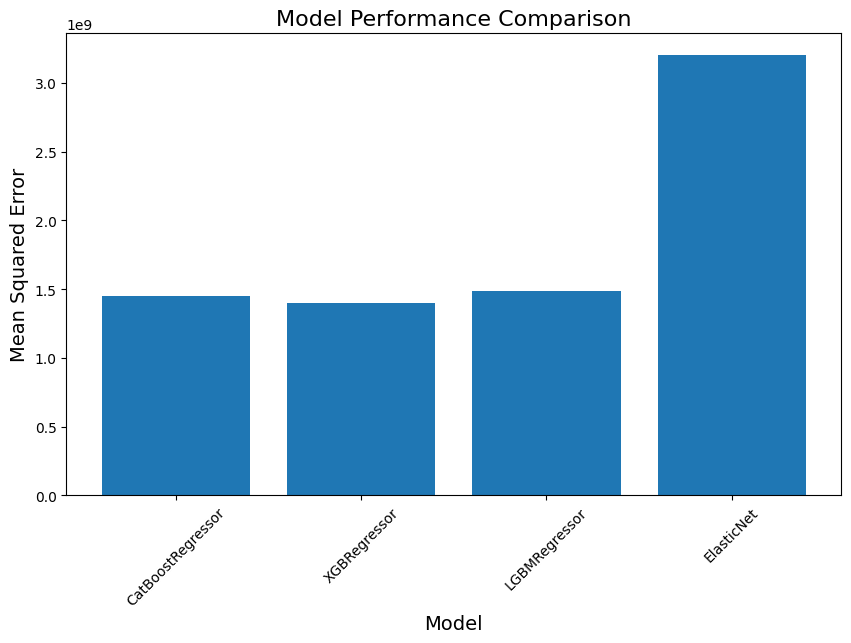

In [3]:

# Create a bar plot
model_names = [model.__class__.__name__ for model in models]
plt.figure(figsize=(10, 6))
plt.bar(model_names, mse_values)
plt.xlabel('Model', fontsize=14)
plt.ylabel('Mean Squared Error', fontsize=14)
plt.xticks(rotation=45)
plt.title('Model Performance Comparison', fontsize=16)
plt.show()



In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import GradientBoostingRegressor
import xgboost as xgb
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.tree import DecisionTreeRegressor

# Create a decision tree regressor
decision_tree = DecisionTreeRegressor(max_depth=10,min_samples_leaf=5,min_samples_split=5)

# Fit the decision tree on the model predictions
decision_tree.fit(model_predictions, y_test)

#Evaluate the decision tree regressor
y_pred_decision_tree = decision_tree.predict(model_predictions)
decision_tree_mse = mean_squared_error(y_test, y_pred_decision_tree)
print(f"Decision Tree Regressor:")
print(f"Mean Squared Error: {decision_tree_mse:.4f}")
print("-" * 30)

Decision Tree Regressor:
Mean Squared Error: 739993449.3944
------------------------------


In [5]:

random_for = RandomForestRegressor(max_depth=4,min_samples_leaf=4,min_samples_split=4,
                                   n_estimators=100,bootstrap=True,criterion='poisson',
                                   max_features='sqrt',oob_score= True,
                                   )
#'bootstrap': True, 'criterion': 'poisson', 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 90, 'oob_score': True
# Fit the decision tree on the model predictions
random_for.fit(model_predictions, y_test)


RandomForestRegressor(criterion='poisson', max_depth=4, max_features='sqrt',
                      min_samples_leaf=4, min_samples_split=4, oob_score=True)

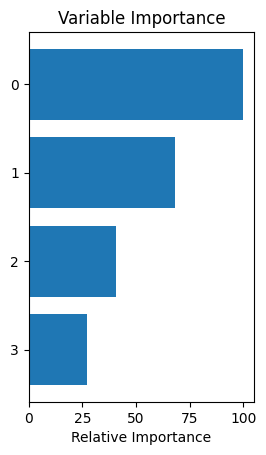

In [6]:
import matplotlib.pyplot as plt
import numpy as np

feature_importance = random_for.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, np.array(model_predictions.columns)[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

In [7]:
# Load the data
dftest = pd.read_csv('data/test.csv').iloc[:,1:].copy()

# Preprocess the data
dftest['BsmtFinSF'] = dftest['BsmtFinSF1'] + dftest['BsmtFinSF2']
dftest['BsmtFinType'] = dftest['BsmtFinType1'].astype(bool) | dftest['BsmtFinType2'].astype(bool)
dftest = dftest.drop(columns=['BsmtFinSF1', 'BsmtFinSF2', 'BsmtFinType1', 'BsmtFinType2'])
# Adding total sqfootage feature 
dftest['TotalSF'] = dftest['TotalBsmtSF'] + dftest['1stFlrSF'] + dftest['2ndFlrSF']
dftest['MSSubClass']= dftest['MSSubClass'].astype(str)

# specify the columns for which you want to compute z-scores
cols = ['LotArea', 'TotalSF','MasVnrArea']

# group by 'Neighborhood' and compute z-scores
for col in cols:
    dftest[f'{col}_z'] = dftest.groupby('Neighborhood')[col].transform(lambda x: zscore(x, ddof=1))

# replace infinite values resulted from division by zero with nan
dftest.replace([np.inf, -np.inf], np.nan, inplace=True)

# Create a list to store the predictions of each base model
base_model_predictions = []

# Make predictions using the base models and store the predictions
for i,model in enumerate(models):  # exclude the decision tree regressor and average blender
    print(model)

    preds=pipelines[i].predict(dftest)
    base_model_predictions.append(preds)

# Convert the base model predictions to a DataFrame
base_model_predictions = pd.DataFrame(base_model_predictions).T





XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.45, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.06, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.075, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=1.7817, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=2200, n_jobs=None, nthread=-1,
             num_parallel_tree=None, ...)
LGBMRegressor(bagging_fraction=0.7, bagging_freq=5, bagging_seed=10,
              feature_fraction=0.25, feature_fraction_seed=18,
              learning_rate=0.075, max_bin=50, min_data_in_leaf=5,
              min_sum_hessian_in_leaf=10, n_estimators=320, n

In [8]:

# Make predictions using the decision tree regressor
final_pred = random_for.predict(base_model_predictions)

In [9]:
# Load the data
dft= pd.read_csv('data/test.csv')
pd.Series(index=dft['Id'],data=final_pred).rename('SalePrice').to_csv('submissions/submission_03292024_8_rf.csv')

In [ ]:
# Make predictions using the decision tree regressor
final_pred_dt = decision_tree.predict(base_model_predictions)

pd.Series(index=dft['Id'],data=final_pred_dt).rename('SalePrice').to_csv('submissions/submission_03292024_4_dt.csv')

In [ ]:
final_pred_b = (final_pred+final_pred_dt)/2

pd.Series(index=dft['Id'],data=final_pred_b).rename('SalePrice').to_csv('submissions/submission_03292024_4_b.csv')